In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import random

In [2]:
path_to_images = '/kaggle/input/teeth-segment/Teeth pictires/images_cut'
path_to_labels = '/kaggle/input/teeth-segment/Teeth pictires/labels_cut'

In [3]:
list_of_image_files = os.listdir(path_to_images)
list_of_label_files = os.listdir(path_to_labels)

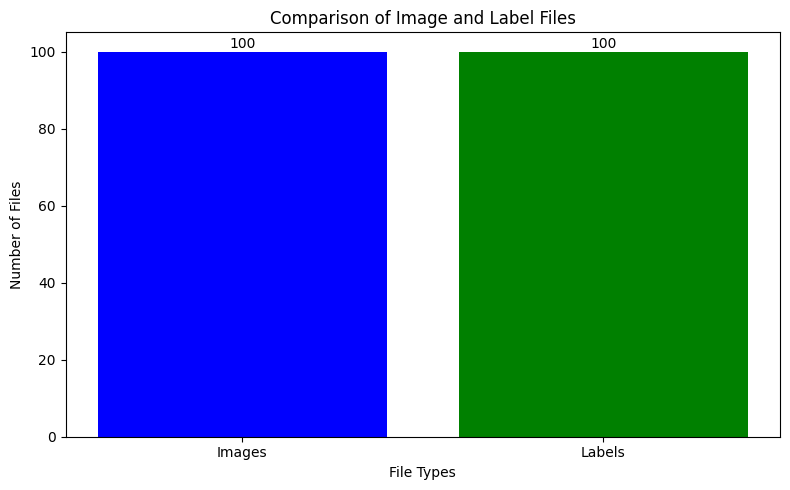

In [4]:
image_file_count = len(list_of_image_files)
label_file_count = len(list_of_label_files)

categories = ['Images', 'Labels']
counts = [image_file_count, label_file_count]

plt.figure(figsize=(8, 5))
plt.bar(categories, counts, color=['blue', 'green'])

plt.xlabel('File Types')
plt.ylabel('Number of Files')
plt.title('Comparison of Image and Label Files')

for i, count in enumerate(counts):
    plt.text(i, count + 1, str(count), ha='center')

plt.tight_layout()
plt.show()

In [5]:
sampled_images = np.random.choice(list_of_image_files, size=15, replace=False)

In [6]:
import cv2 

dimension = 512
target_size = (dimension, dimension)

def load_and_process_image(file_path):
    image = cv2.imread(file_path)
    image = cv2.resize(image, target_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
count=200
grid_rows = 5
grid_cols = 3

figure, axes = plt.subplots(grid_rows, grid_cols, figsize=(10, 10))
for index, axis in enumerate(axes.flatten()):
    if index < len(sampled_images):  
        image_path = f"{path_to_images}/{sampled_images[index]}"
        processed_image = load_and_process_image(image_path)
        axis.set_title(sampled_images[index])
        axis.imshow(processed_image)
        axis.axis('off')

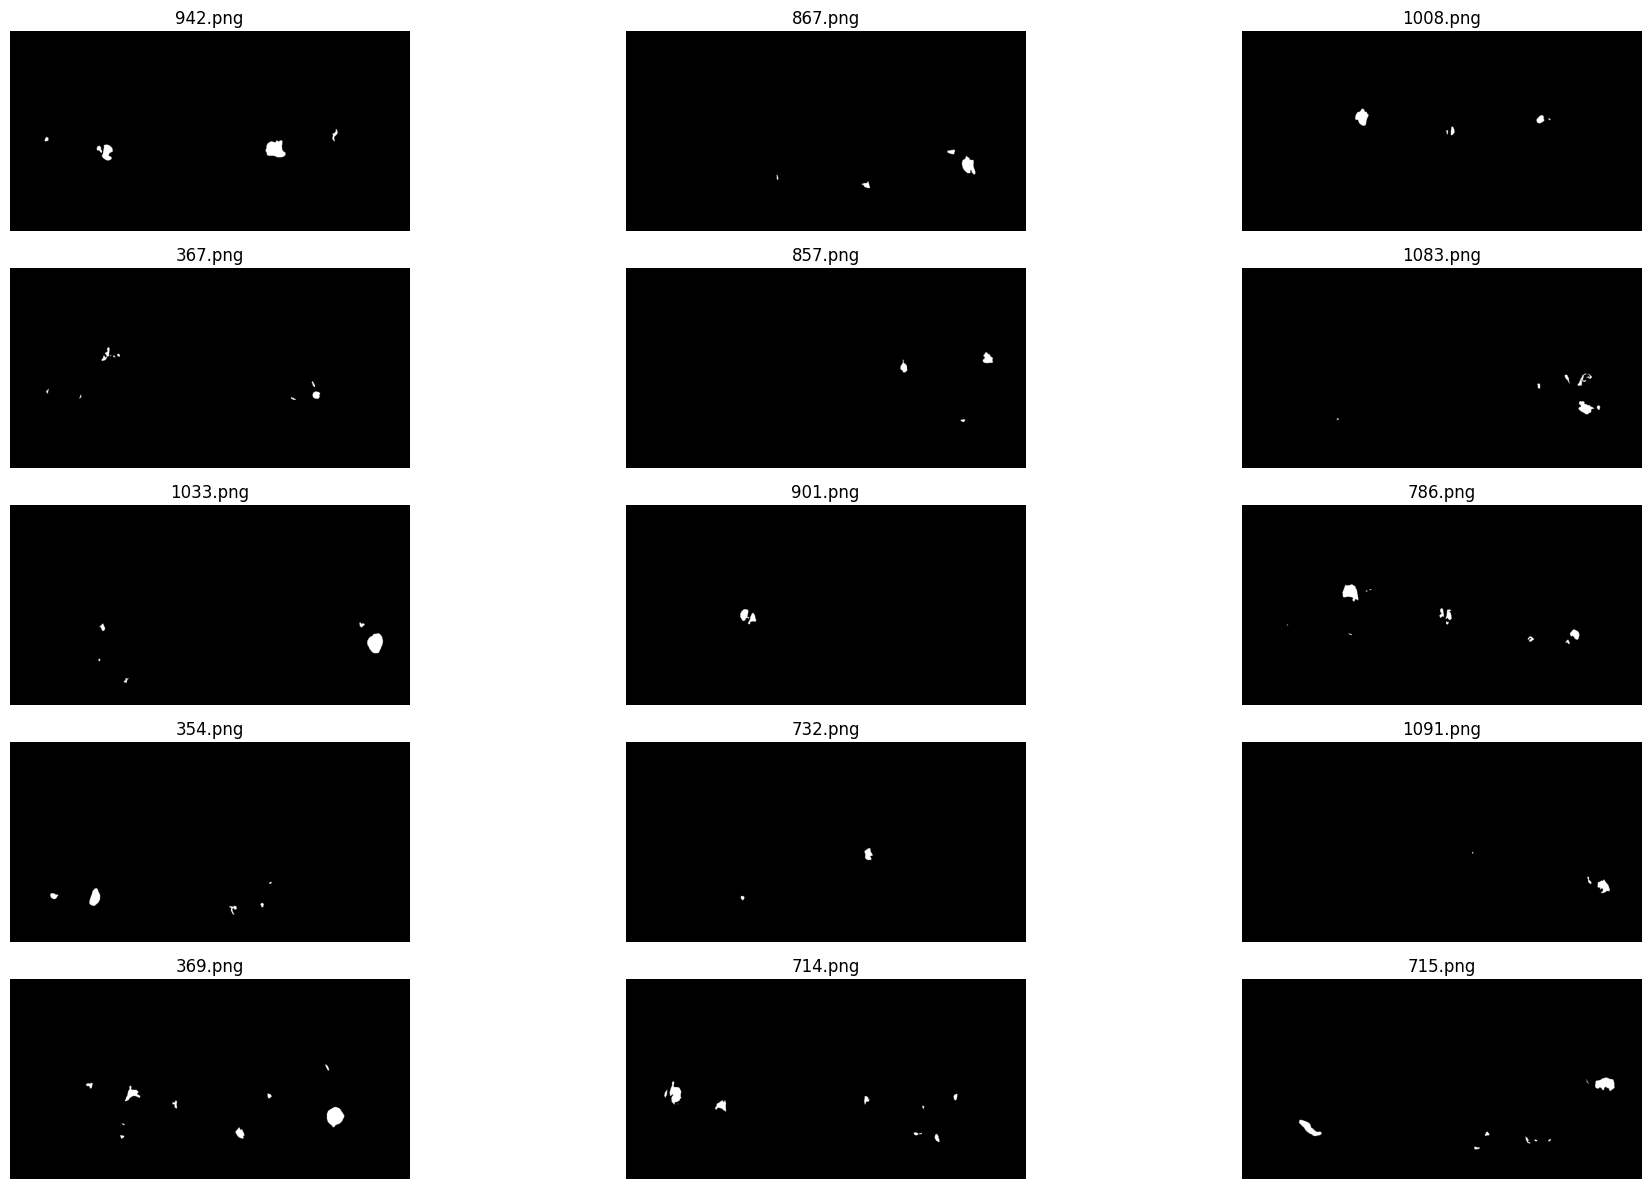

In [8]:
# Original Verification Masks

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(20, 12)) 
for i, ax in enumerate(axes.flatten()):
    if i < len(sampled_images):
        file_name = sampled_images[i]
        file_path = os.path.join(path_to_labels, file_name)
        if os.path.exists(file_path):
            img = cv2.imread(file_path, cv2.COLOR_BGR2GRAY) 
            ax.set_title(file_name)
            ax.imshow(img, cmap='gray')  
            ax.axis('off')
        else:
            ax.set_title('Missing')
            ax.axis('off')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

In [9]:
PREPARED_MASKS = np.zeros((1, dimension, dimension, 1), dtype=bool)
PREPARED_IMAGES = np.zeros((1, dimension, dimension, 3), dtype=np.uint8)

In [10]:
for idx, filename in enumerate(os.listdir(path_to_images)[:count]):
    try:
        processed_image = load_and_process_image(os.path.join(path_to_images, filename))
        expanded_image = np.expand_dims(processed_image, axis=0)
        PREPARED_IMAGES = np.vstack((PREPARED_IMAGES, expanded_image))

        processed_mask = load_and_process_image(os.path.join(path_to_labels, filename))
        gray_mask = cv2.cvtColor(processed_mask, cv2.COLOR_BGR2GRAY)
        reshaped_mask = gray_mask.reshape(dimension, dimension, 1)
        expanded_mask = np.expand_dims(reshaped_mask, axis=0)
        PREPARED_MASKS = np.vstack((PREPARED_MASKS, expanded_mask))

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

In [11]:
final_images = np.array(PREPARED_IMAGES)[1:count+1]
final_masks = np.array(PREPARED_MASKS)[1:count+1]

print(final_images.shape, final_masks.shape)

(100, 512, 512, 3) (100, 512, 512, 1)


In [12]:
from sklearn.model_selection import train_test_split

training_images, validation_images, training_labels, validation_labels = train_test_split(
    final_images,final_masks, test_size=0.4, random_state=42)

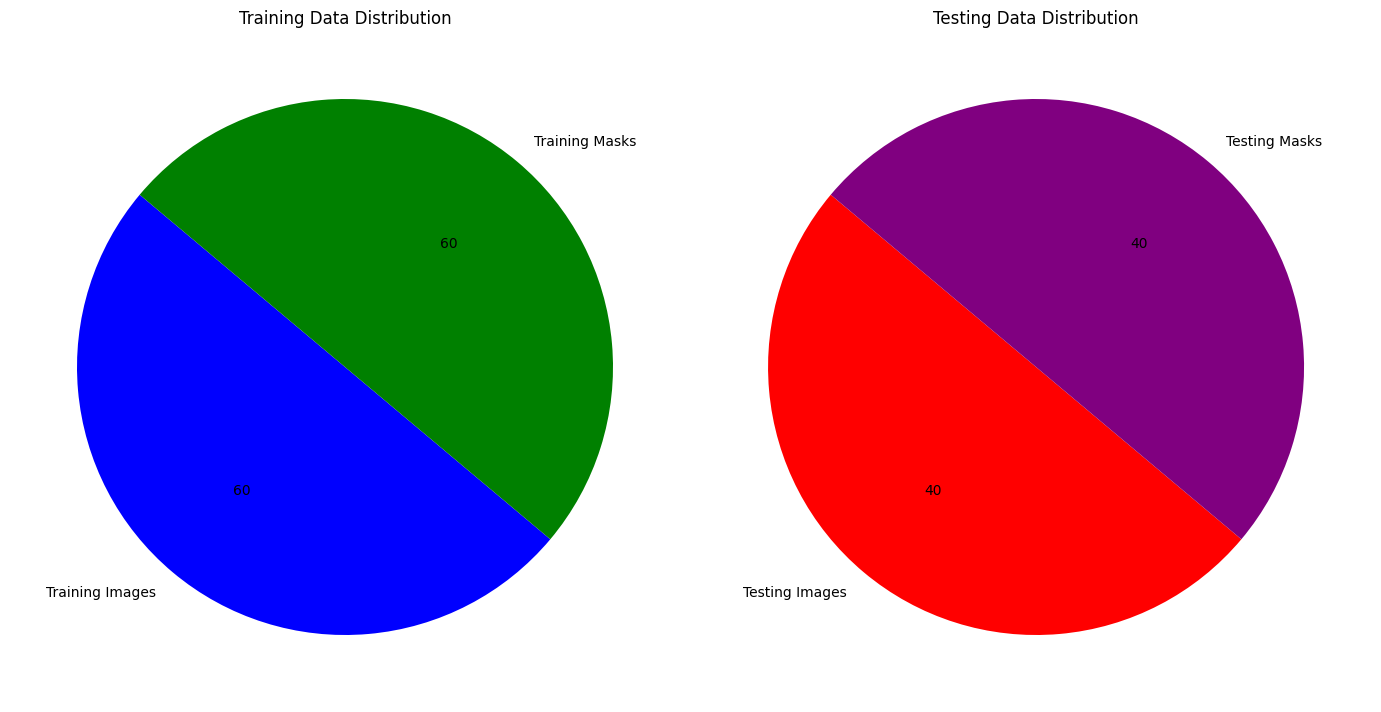

In [13]:
training_data_size = len(training_images) 
training_labels_size = len(training_labels) 
testing_data_size = len(validation_images) 
testing_labels_size = len(validation_labels)  

train_sizes = [training_data_size, training_labels_size]
test_sizes = [testing_data_size, testing_labels_size]
train_labels = ['Training Images', 'Training Masks']
test_labels = ['Testing Images', 'Testing Masks']

def absolute_value(val, total):
    return int(round(val/100.*total))

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].pie(train_sizes, labels=train_labels, autopct=lambda val: absolute_value(val, sum(train_sizes)), startangle=140, colors=['blue', 'green'])
axs[0].set_title('Training Data Distribution')

axs[1].pie(test_sizes, labels=test_labels, autopct=lambda val: absolute_value(val, sum(test_sizes)), startangle=140, colors=['red', 'purple'])
axs[1].set_title('Testing Data Distribution')

plt.tight_layout()
plt.show()

In [14]:
import tensorflow as tf

def convolutional_block(input, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def encoding_block(input, filters):
    skip_connection = convolutional_block(input, filters)
    pooled = tf.keras.layers.MaxPool2D((2, 2))(skip_connection)
    return skip_connection, pooled

def decoding_block(input, skip_connection, filters):
    x = tf.keras.layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(input)
    x = tf.keras.layers.Concatenate()([x, skip_connection])
    x = convolutional_block(x, filters)
    return x

def build_unet_model(input_shape, base_filters=32):  # Уменьшенное начальное количество фильтров
    inputs = tf.keras.layers.Input(input_shape)

    skip_connection1, pool1 = encoding_block(inputs, 32)
    skip_connection2, pool2 = encoding_block(pool1, 64)
    skip_connection3, pool3 = encoding_block(pool2, 128)
    skip_connection4, pool4 = encoding_block(pool3, 256)
    bridge = convolutional_block(pool4, 512)

    decode_block1 = decoding_block(bridge, skip_connection4, 256)
    decode_block2 = decoding_block(decode_block1, skip_connection3, 128)
    decode_block3 = decoding_block(decode_block2, skip_connection2, 64)
    decode_block4 = decoding_block(decode_block3, skip_connection1, 32)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode_block4)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Refactored-U-Net")
    return model

# Создание упрощенной модели с базовыми фильтрами 32
refactored_unet_model = build_unet_model((512, 512, 3), base_filters=32)
refactored_unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


2024-04-04 19:45:48.396835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 19:45:48.396935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 19:45:48.526852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
training_history = refactored_unet_model.fit(training_images, training_labels,validation_split=0.2, batch_size=4,epochs=130)

Epoch 1/130


2024-04-04 19:46:12.942825: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.28217, expected 2.80856
2024-04-04 19:46:12.942888: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 20: 3.65984, expected 3.18622
2024-04-04 19:46:12.942907: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 146: 3.18374, expected 2.71012
2024-04-04 19:46:12.942924: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 289: 3.72308, expected 3.24946
2024-04-04 19:46:12.942937: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 467: 3.36379, expected 2.89017
2024-04-04 19:46:12.943003: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6144: 3.64194, expected 3.16832
2024-04-04 19:46:12.943423: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 56320: 3.51982, expected 3.0462
2024-04-04 19:46:12.943595: E external/loc

 1/12 ━━━━━━━━━━━━━━━━━━━━ 7:36 41s/step - accuracy: 0.5202 - loss: 0.5485

I0000 00:00:1712260000.578674      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 315ms/step - accuracy: 0.5950 - loss: -0.9691 - val_accuracy: 3.2107e-05 - val_loss: -3080.4988
Epoch 2/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.8175 - loss: -5.9596 - val_accuracy: 0.0000e+00 - val_loss: -15406.5771
Epoch 3/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.8321 - loss: -8.3109 - val_accuracy: 0.0083 - val_loss: -11187.5205
Epoch 4/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.8460 - loss: -9.4220 - val_accuracy: 0.0074 - val_loss: -2593.9358
Epoch 5/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.8256 - loss: -14.2144 - val_accuracy: 0.0032 - val_loss: -1920.6283
Epoch 6/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.7094 - loss: -12.9494 - val_accuracy: 0.0236 - val_loss: -1855.6865
Epoch 7/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.7977 - loss: -19.1244 - val_accuracy: 0.9815 - val_loss: 3.2990
Epoch 8/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy:

In [16]:
def display_segmentation(idx, original_img, predicted_mask, true_mask, threshold):
    figure, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].set_title(f"Original Image #{idx}")
    axes[0].imshow(original_img)
    axes[0].axis('off')

    axes[1].set_title(f"U-Net Prediction (Threshold: {threshold})")
    axes[1].imshow(predicted_mask, cmap='gray')
    axes[1].axis('off')

    axes[2].set_title("Ground Truth Mask")
    axes[2].imshow(true_mask, cmap='gray')
    axes[2].axis('off')

    plt.show()

In [17]:
predictions = refactored_unet_model.predict(validation_images)

2024-04-04 19:50:52.119035: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,32,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,512,512]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-04 19:50:53.012651: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.21244, expected 2.29141
2024-04-04 19:50:53.012705: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.49015, expected 3.56912
2024-04-04 19:50:53.012715: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.96535, expected 3.04432
2024-04-04 19:50:53.012723: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] D

1/2 ━━━━━━━━━━━━━━━━━━━━ 54s 55s/step

2024-04-04 19:51:46.057269: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.56918, expected 2.8525
2024-04-04 19:51:46.057321: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.56898, expected 4.85231
2024-04-04 19:51:46.057330: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.7052, expected 3.98853
2024-04-04 19:51:46.057338: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.01271, expected 4.29603
2024-04-04 19:51:46.057346: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.54539, expected 3.82871
2024-04-04 19:51:46.057354: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.41696, expected 4.70029
2024-04-04 19:51:46.057361: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.06138, expected 4.34471
2024-04-04 19:51:46.057369: E external/local_xla/xla/serv

2/2 ━━━━━━━━━━━━━━━━━━━━ 70s 16s/step


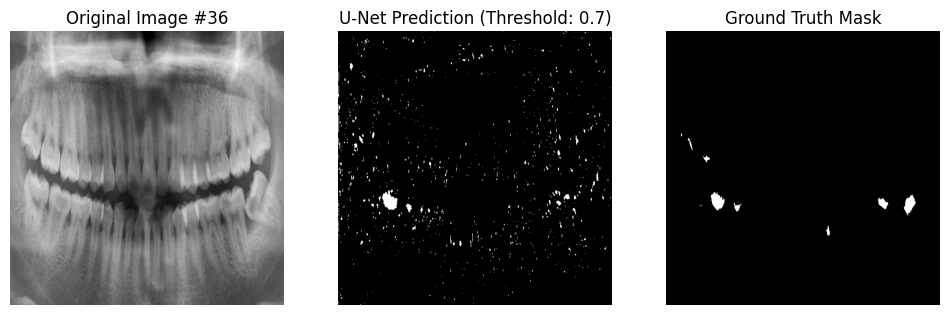

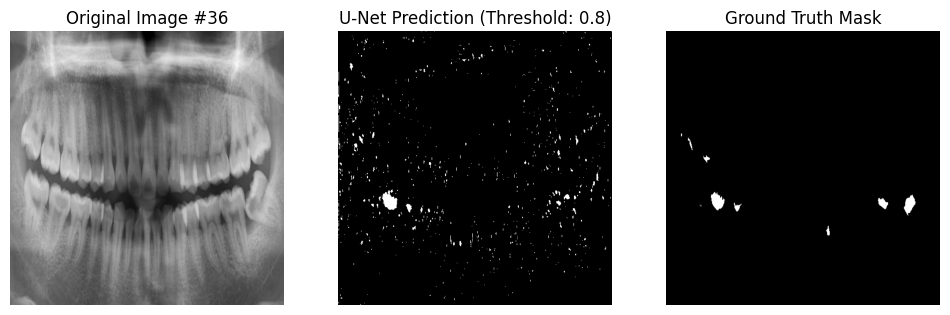

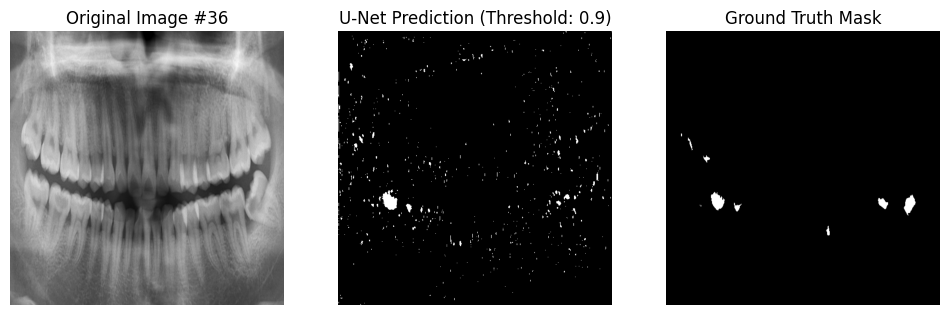

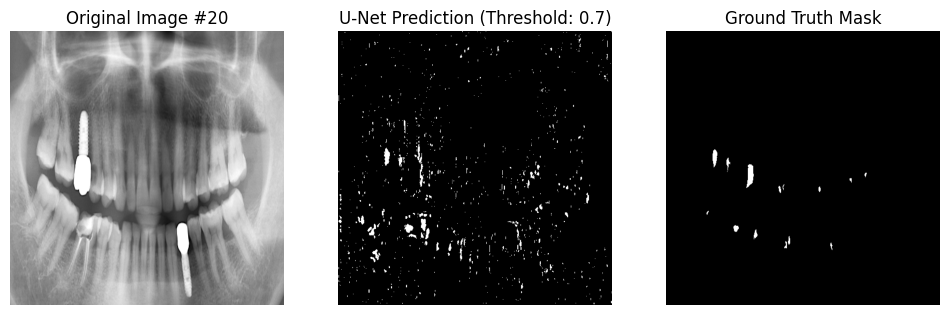

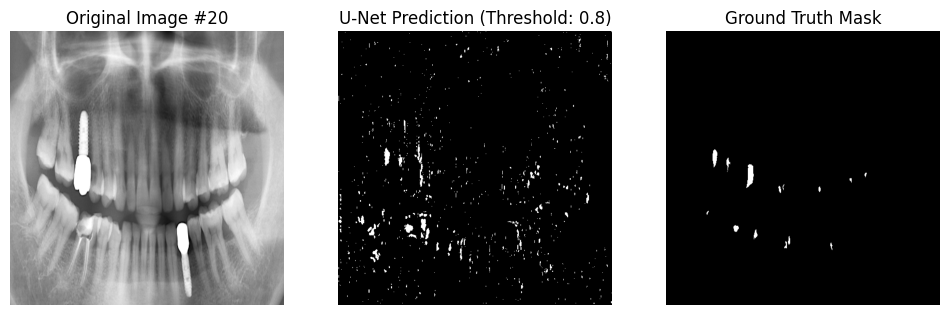

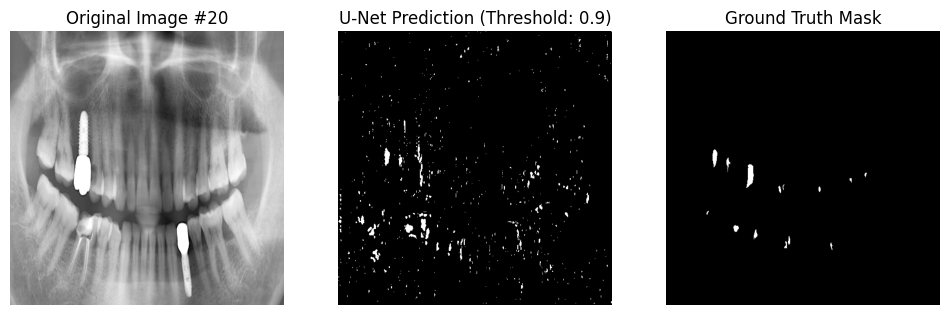

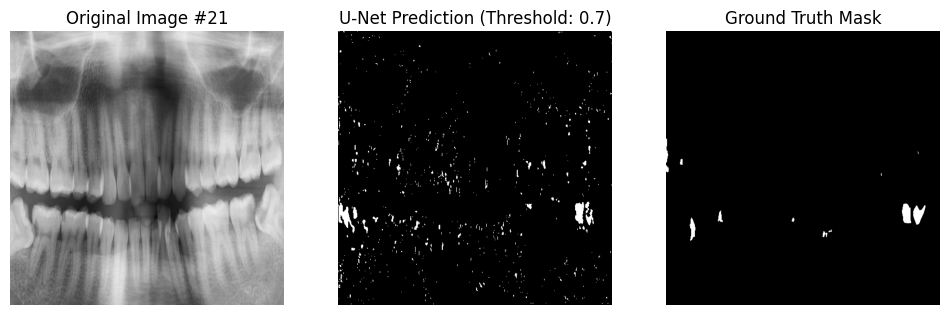

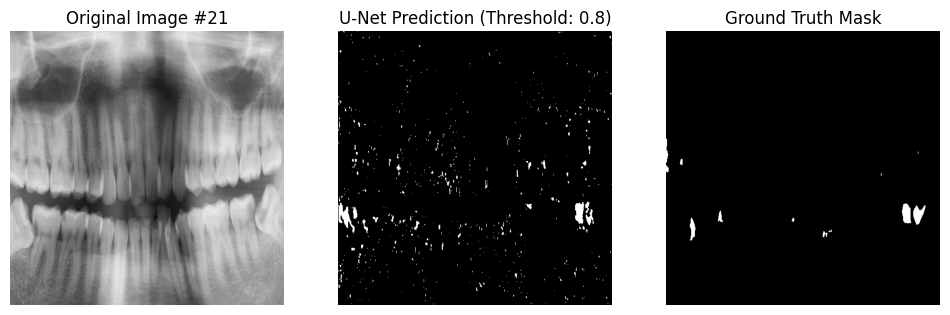

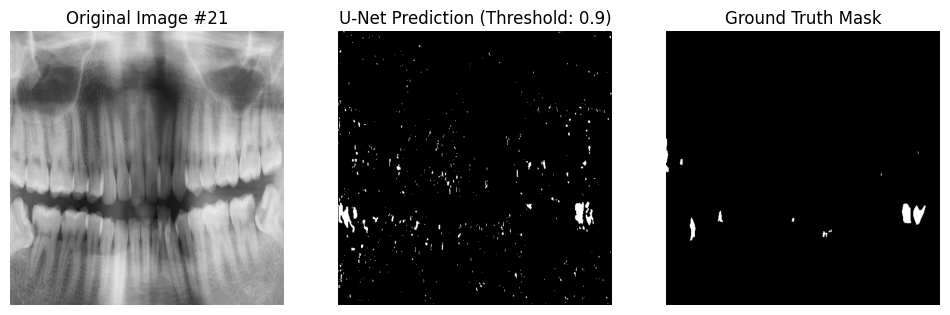

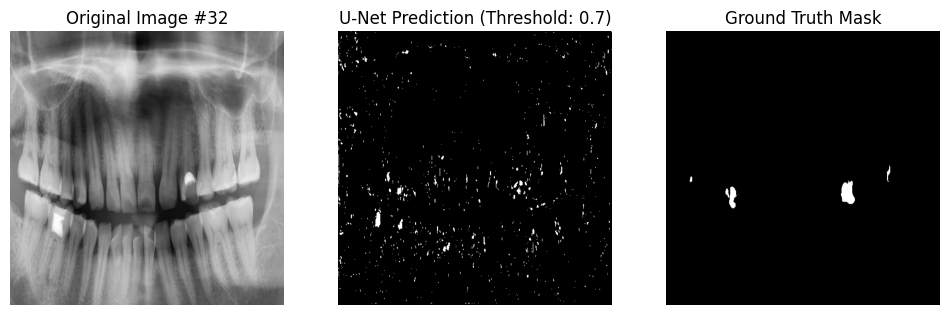

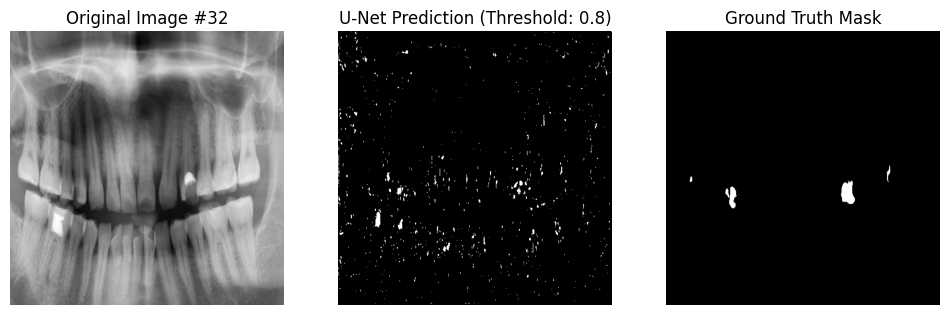

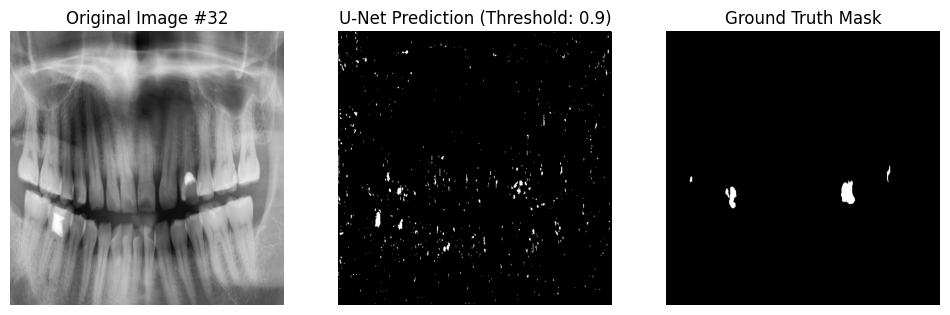

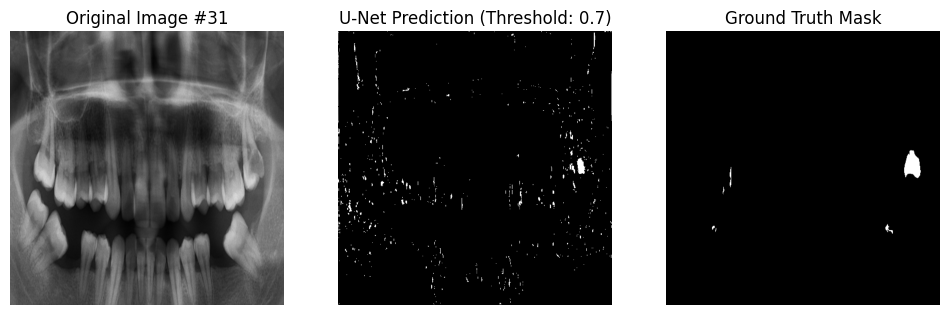

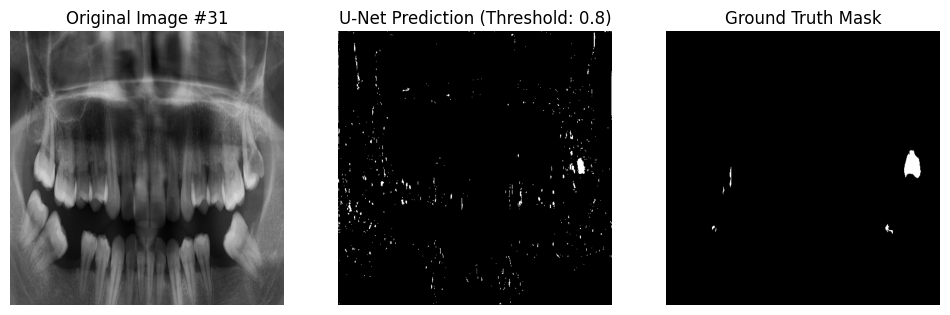

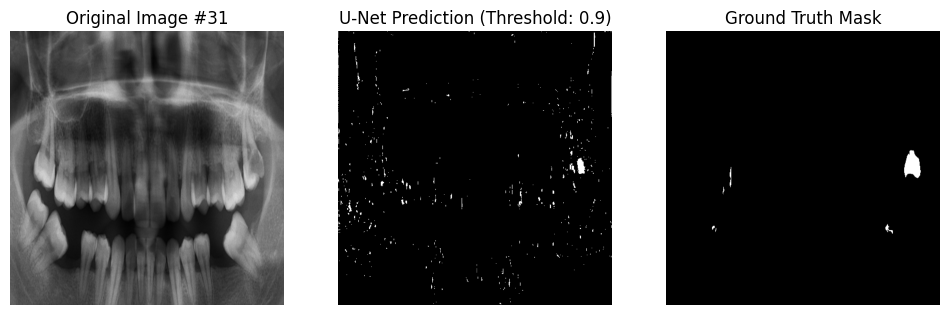

In [18]:
thresholds = [0.7, 0.8, 0.9]

segmentation_masks = [(predictions > threshold).astype(np.uint8) for threshold in thresholds]
sample_indices = random.sample(range(len(predictions)), 5)

for index in sample_indices:
    for mask, threshold in zip(segmentation_masks, thresholds):
        display_segmentation(index, validation_images[index], mask[index], validation_labels[index], threshold)
    print()  

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Предположим, что ваши предсказания и истинные метки имеют форму (количество примеров, высота, ширина)
# Например, для задачи сегментации изображений
binary_predictions = (predictions > 0.5).astype(np.uint8)  # Бинаризация
y_true = validation_labels.flatten()  # Выравнивание истинных меток
y_pred = binary_predictions.flatten()  # Выравнивание предсказаний

# Расчет матрицы ошибок
conf_matrix = confusion_matrix(y_true, y_pred)


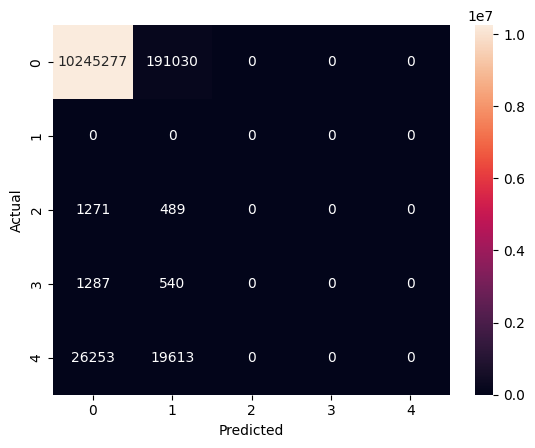

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()